In [1]:
# Read the numerical model output, make some maps to check the conditions, crop the fields of interest in the areas
# of interest and save them in a netcdf file.

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [104]:
# To plot maps.
crs = ccrs.PlateCarree()

def plot_background(ax):
    #ax.set_extent(extent_param)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    #ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'fontsize': 14}
    gl.ylabel_style = {'fontsize': 14}
    return ax

In [ ]:
# Set the paths and the file names of the (coupled) oceanic and atmospheric model outputs.
path2atm = '/mnt/storage_unimib/agostino/genoa2014/3CPLD/'
path2oce = '/mnt/storage_unimib/agostino/genoa2014/3CPLD/CPLD_HIS/'

In [41]:
# Set the instant of interest.
str_instant = '2014-10-07T12:00:00'
# Valid range: from 2014-10-06_00:00:00 to 2014-10-10_00:00:00.

atm_filename = path2atm + 'wrfout_d01_' + str_instant[:10] + '_' + str_instant[11:]
oce_filename = path2oce + 'roms_cpld_his.0020.nc' 
# If str_instant is after '2014-10-07T12:00:00' select the roms_cpld_his.0025.nc file

In [141]:
# Read the oceanic grid file.
oce_grd_filename = '/mnt/storage_unimib/agostino/genoa2014/3CPLD/spinup/INPUTS/roms_grd.nc'
ds_oce_grd = xr.open_dataset(oce_grd_filename)
lon_oce = ds_oce_grd['lon_rho'].values
lat_oce = ds_oce_grd['lat_rho'].values
mask_oce = ds_oce_grd['mask_rho'].values
angle_oce = ds_oce_grd['angle'][1:,1:].values*np.pi/180

# Read the output files.
ds_oce = xr.open_dataset(oce_filename)
ds_atm = xr.open_dataset(atm_filename)

# Select the right frame in the oceanic output and read the appropriate variables.
ref_instant = np.datetime64(str_instant)
time0 = np.datetime64('2014-09-15T00:00:00') # Time of the initialization of the oceanic output time axis.
time_oce = time0 + ds_oce.time.values.astype('timedelta64[s]')

for hi in range(len(time_oce)):
    instant = time_oce[hi]
    if instant == ref_instant:
        print(instant)
        # Unstagger the current components while reading them.
        uc_mod = 0.5*(ds_oce['u'][hi,-1,1:,:].values + ds_oce['u'][hi,-1,:-1,:].values)
        vc_mod = 0.5*(ds_oce['v'][hi,-1,:,1:].values + ds_oce['v'][hi,-1,:,:-1].values) 
        uc = uc_mod*np.cos(angle_oce) - vc_mod*np.sin(angle_oce)
        vc = uc_mod*np.sin(angle_oce) + vc_mod*np.cos(angle_oce)
        sst_oce = ds_oce['temp'][hi,-1,:,:].values
        
# Select the atmospheric variables of interest.
lon_atm = ds_atm['XLONG'][0].values
lat_atm = ds_atm['XLAT'][0].values
sst_atm = ds_atm['SST'][0].values
u10_mod = ds_atm['U10'][0].values
v10_mod = ds_atm['V10'][0].values
cosalpha = ds_atm['COSALPHA'][0].values
sinalpha = ds_atm['SINALPHA'][0].values
u10 = u10_mod*cosalpha - v10_mod*sinalpha
v10 = u10_mod*sinalpha + v10_mod*cosalpha

2014-10-07T12:00:00


<ipython-input-127-cd3d4d3c3f7b>:4: RuntimeWarning: divide by zero encountered in true_divide
  pc = plt.pcolormesh(lon_oce,lat_oce,np.sqrt(uc**2+vc**2)/mask_oce[1:,1:])
<ipython-input-127-cd3d4d3c3f7b>:4: RuntimeWarning: invalid value encountered in true_divide
  pc = plt.pcolormesh(lon_oce,lat_oce,np.sqrt(uc**2+vc**2)/mask_oce[1:,1:])


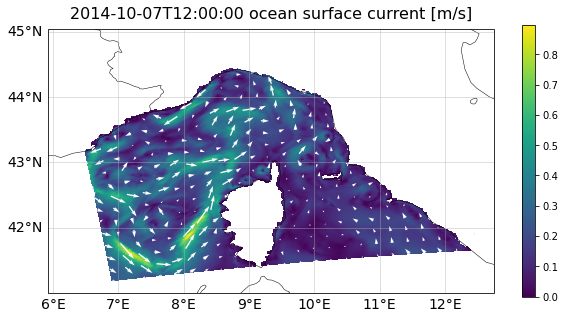

In [127]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1, projection=crs)
plot_background(ax)
pc = plt.pcolormesh(lon_oce,lat_oce,np.sqrt(uc**2+vc**2)/mask_oce[1:,1:])
step = 15
qv = plt.quiver(lon_oce[::step,::step],lat_oce[::step,::step],uc[::step,::step],vc[::step,::step],
                color='w',scale=15)

plt.title(str_instant + ' ocean surface current [m/s]', fontsize=16)
plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude',fontsize=14)
plt.colorbar(pc)

<ipython-input-134-6f926596f851>:4: RuntimeWarning: invalid value encountered in true_divide
  pc = plt.pcolormesh(lon_oce,lat_oce,sst_oce/mask_oce,vmin=19.5,vmax=24.5)


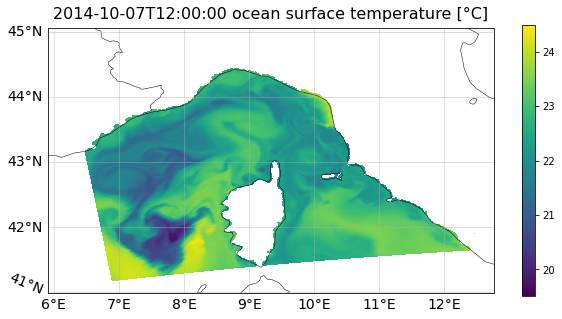

In [134]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1, projection=crs)
plot_background(ax)
pc = plt.pcolormesh(lon_oce,lat_oce,sst_oce/mask_oce,vmin=19.5,vmax=24.5)
step = 15
#qv = plt.quiver(lon_oce[::step,::step],lat_oce[::step,::step],uc[::step,::step],vc[::step,::step],
#                color='w',scale=15)

plt.title(str_instant + ' ocean surface temperature [°C]', fontsize=16)
plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude',fontsize=14)
plt.colorbar(pc)

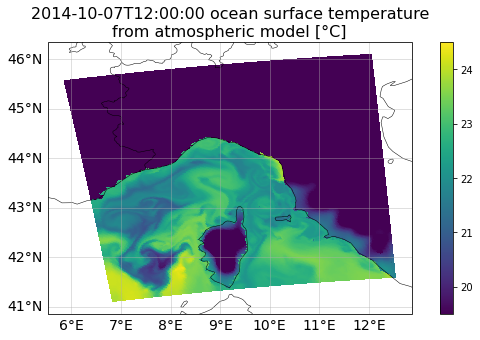

In [146]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1, projection=crs)
plot_background(ax)
pc = plt.pcolormesh(lon_atm,lat_atm,sst_atm-273.15,vmin=19.5,vmax=24.5)
step = 15

plt.title(str_instant + ' ocean surface temperature\nfrom atmospheric model [°C]', fontsize=16)
plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude',fontsize=14)
plt.colorbar(pc)

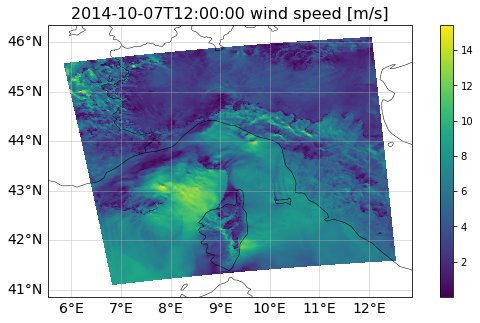

In [150]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1, projection=crs)
plot_background(ax)
pc = plt.pcolormesh(lon_atm,lat_atm,np.sqrt(u10**2+v10**2))
step = 15

plt.title(str_instant + ' wind speed [m/s]', fontsize=16)
plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude',fontsize=14)
plt.colorbar(pc)